# Q1: Sampling a 2d target

In [6]:
from scipy import stats
import numpy as np
from matplotlib import pyplot as plt
from tqdm.notebook import trange, tqdm
import pandas as pd

## 1.1 Direct sampling
insert derivation of transformation and sampling here

In [26]:
def sample_r(k, N=1):
    a = k/2
    b = 1/2
    return stats.gamma.rvs(a, scale=1/b, size=N)

def sample_theta(N=1):
    return stats.uniform.rvs(scale=2*np.pi, size=N)

In [28]:
def direct_sampling(k, N=100000):
    rs = sample_r(k=k, N=N)
    ts = sample_theta(N=N)

    xs = rs * np.cos(ts)
    ys = rs * np.sin(ts)

    return xs, ys

In [30]:
def target_density(x, y, k):
    r2 = x**2 + y**2
    r = np.sqrt(r2)
    return (r2)**(k / 4 - 1) * np.exp(-r / 2)

def get_target_density_samples(k):
    x = np.linspace(-2*k, 2*k, 300)
    y = np.linspace(-2*k, 2*k, 300)
    X, Y = np.meshgrid(x, y)
    z = target_density(X, Y, k)
    z /= z.sum()
    return X, Y, z

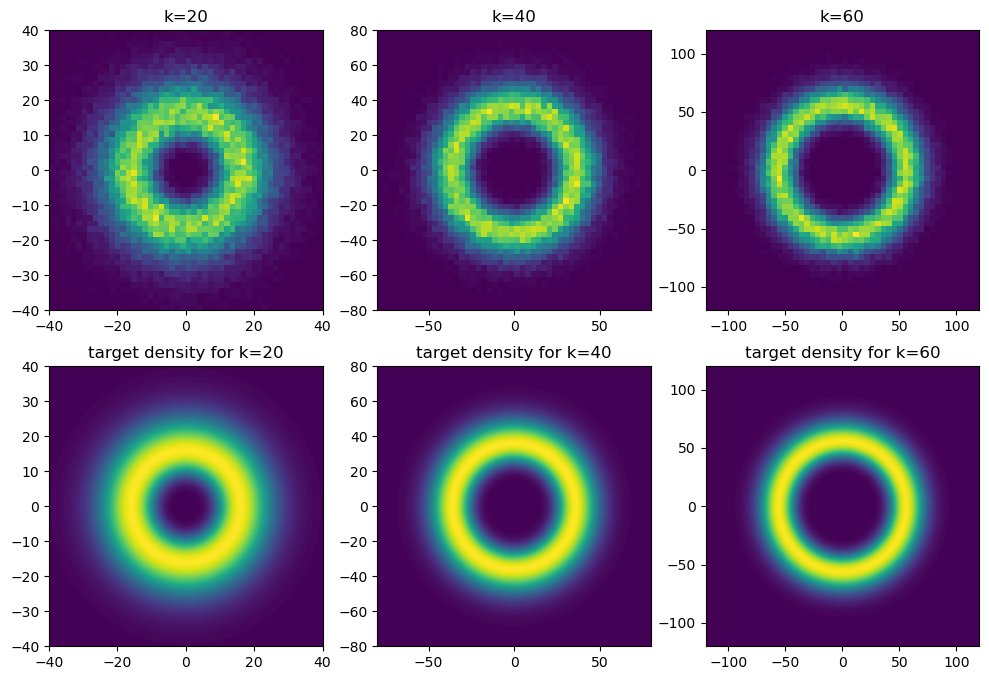

In [380]:
ks = [20, 40, 60]

fig, ax = plt.subplots(ncols=3, nrows=2, figsize=(12, 8))

for i, k in enumerate(ks):
    x, y = direct_sampling(k=k)
    ax[0][i].hist2d(x, y, range=[[-2*k, 2*k], [-2*k, 2*k]], bins=50, cmap='viridis')
    ax[0][i].set_title(f'k={k}')

    X, Y, Z = get_target_density_samples(k=k)
    ax[1][i].contourf(X, Y, Z, levels=100)
    ax[1][i].set_title(f'target density for k={k}')
    
plt.show()

## 1.2 Metropolis-Hastings sampler

In [32]:
def target_distribution(x: float, y: float, k: int, epsilon: float = 10e-9) -> float:
    return max((x**2 + y**2)**(k/4 - 1) * np.exp(-(np.sqrt(x**2 + y**2)) / 2), epsilon)

In [34]:
def metropolis_hastings_random_walk(k, N=100000, sigma=1, target_dist=target_distribution):
    x_samples, y_samples = [], []
    x, y = 0, 0
    accepted_samples = 0
    
    progress_bar = tqdm(total=N, leave=True)
    while len(x_samples) < N:
        x1 = stats.norm.rvs(loc=x, scale=sigma)
        y1 = stats.norm.rvs(loc=y, scale=sigma)

        a = min(1, (target_dist(x1, y1, k=k)) / (target_dist(x, y, k=k)))
        
        if stats.uniform.rvs() < a:
            x, y = x1, y1
            accepted_samples += 1
            
        x_samples.append(x)
        y_samples.append(y)
        progress_bar.update(1)

    # Compute acceptance rate
    acceptance_rate = accepted_samples / N
    print(f"Acceptance rate: {acceptance_rate:.2f}")
            
    return np.array(x_samples), np.array(y_samples)

### identifying burn in for each k

In [369]:
mh_xs, mh_ys = [], []
for k in ks:
    x, y = metropolis_hastings_random_walk(k=k, sigma=(0.7*k), N=100000)
    mh_xs.append(x)
    mh_ys.append(y)

  0%|          | 0/100000 [00:00<?, ?it/s]

Acceptance rate: 0.49


  0%|          | 0/100000 [00:00<?, ?it/s]

Acceptance rate: 0.38


  0%|          | 0/100000 [00:00<?, ?it/s]

Acceptance rate: 0.33


We tune $\sigma$ by hand to reach a target acceptance rate within the range $(0.3, 0.5)$. This gives us an indication that the proposal sampler explores all if the target domain and also has good exploitation of high density areas in our target distribution.

It makes sense to scale sigma by $k$ as this correlates to the radius of the distribution which also scales roughly linearly according to $k$ (a can be seen in the direct sampling plots). We want a $k$ that allows us to jump from one side of the circle to the other with 

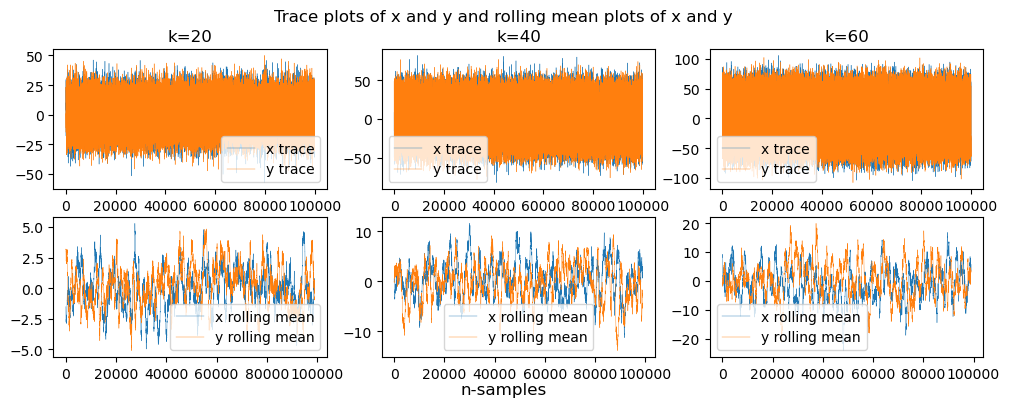

In [372]:
def moving_window_mean(data: list, window_size=100):
    return pd.Series(data).rolling(window=window_size).mean().to_numpy()[window_size-1:]

fig, ax = plt.subplots(ncols=3, nrows=2, figsize=(12, 4))

for i, (k, x, y) in enumerate(zip(ks, mh_xs, mh_ys)):
    ax[0][i].plot(x, label='x trace', lw=0.3)
    ax[0][i].plot(y, label='y trace', lw=0.3)
    ax[0][i].set_title(f"k={k}")
    ax[0][i].legend()
    
    x_running_mean = moving_window_mean(x.flatten().tolist(), window_size=1000)
    y_running_mean = moving_window_mean(y.flatten().tolist(), window_size=1000)
    ax[1][i].plot(x_running_mean, label='x rolling mean', lw=0.3)
    ax[1][i].plot(y_running_mean, label='y rolling mean', lw=0.3)
    ax[1][i].legend()
    
fig.supxlabel('n-samples')
fig.suptitle('Trace plots of x and y and rolling mean plots of x and y')
plt.show()

We can see that starting at $(0, 0)$, there is virtually no burn-in period. Immediately the samples randomly walk mean a mean of approximately 0 in both x and y dimensions.

We will still discard the first 10% (10,000) of samples for good measure.

k=20, no. of burn in samples removed: 10000, no. of samples remaining: 90000
k=40, no. of burn in samples removed: 10000, no. of samples remaining: 90000
k=60, no. of burn in samples removed: 10000, no. of samples remaining: 90000


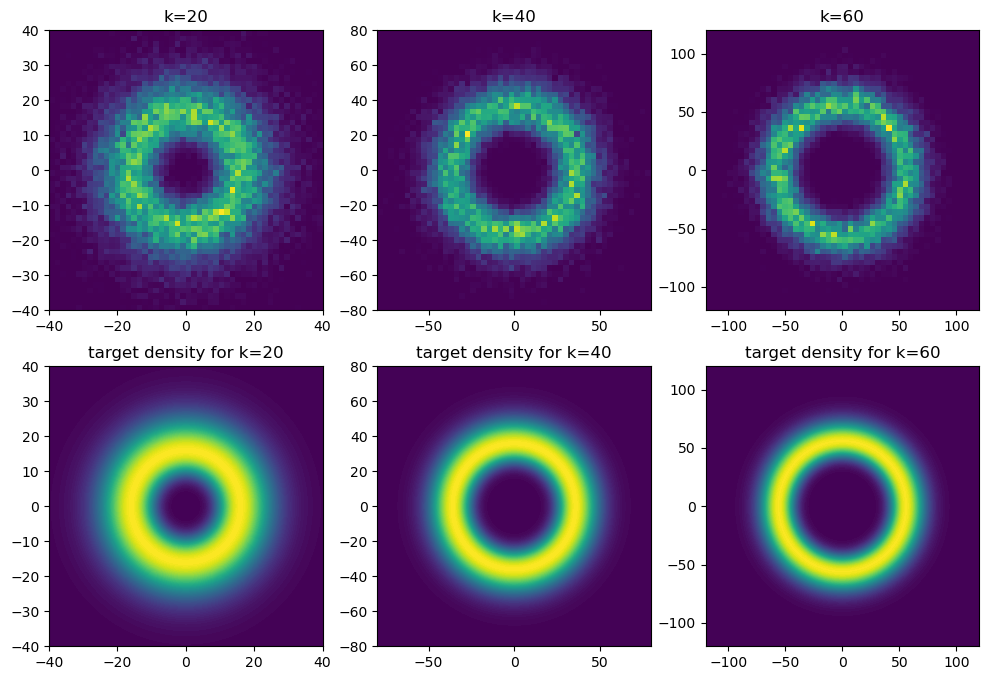

In [384]:
fig, ax = plt.subplots(ncols=3, nrows=2, figsize=(12, 8))
burnin_percentage = 0.1

for i, (k, x, y) in enumerate(zip(ks, mh_xs, mh_ys)):
    
    burnin = int(np.floor(burnin_percentage * len(x)))
    print(f'k={k}, no. of burn in samples removed: {burnin}, no. of samples remaining: {len(x) - burnin}')
    
    ax[0][i].hist2d(x[burnin:], y[burnin:], bins=50, cmap='viridis', range=[[-2*k, 2*k], [-2*k, 2*k]])
    ax[0][i].set_title(f"k={k}")

    X, Y, Z = get_target_density_samples(k=k)
    ax[1][i].contourf(X, Y, Z, levels=100)
    ax[1][i].set_title(f'target density for k={k}')
    
plt.show()

## 1.3 Metropolis-adjusted Langevin algorithm (MALA)

In [330]:
def gradient_log_target(x, y, k, epsilon=10e-9):
    r = np.sqrt(np.maximum(x**2 + y**2, epsilon))
    factor = (k / 4 - 1) * 2 / r - 1/2
    def grad(v):
        nonlocal factor, r
        return v/r * factor
    return grad(x), grad(y)

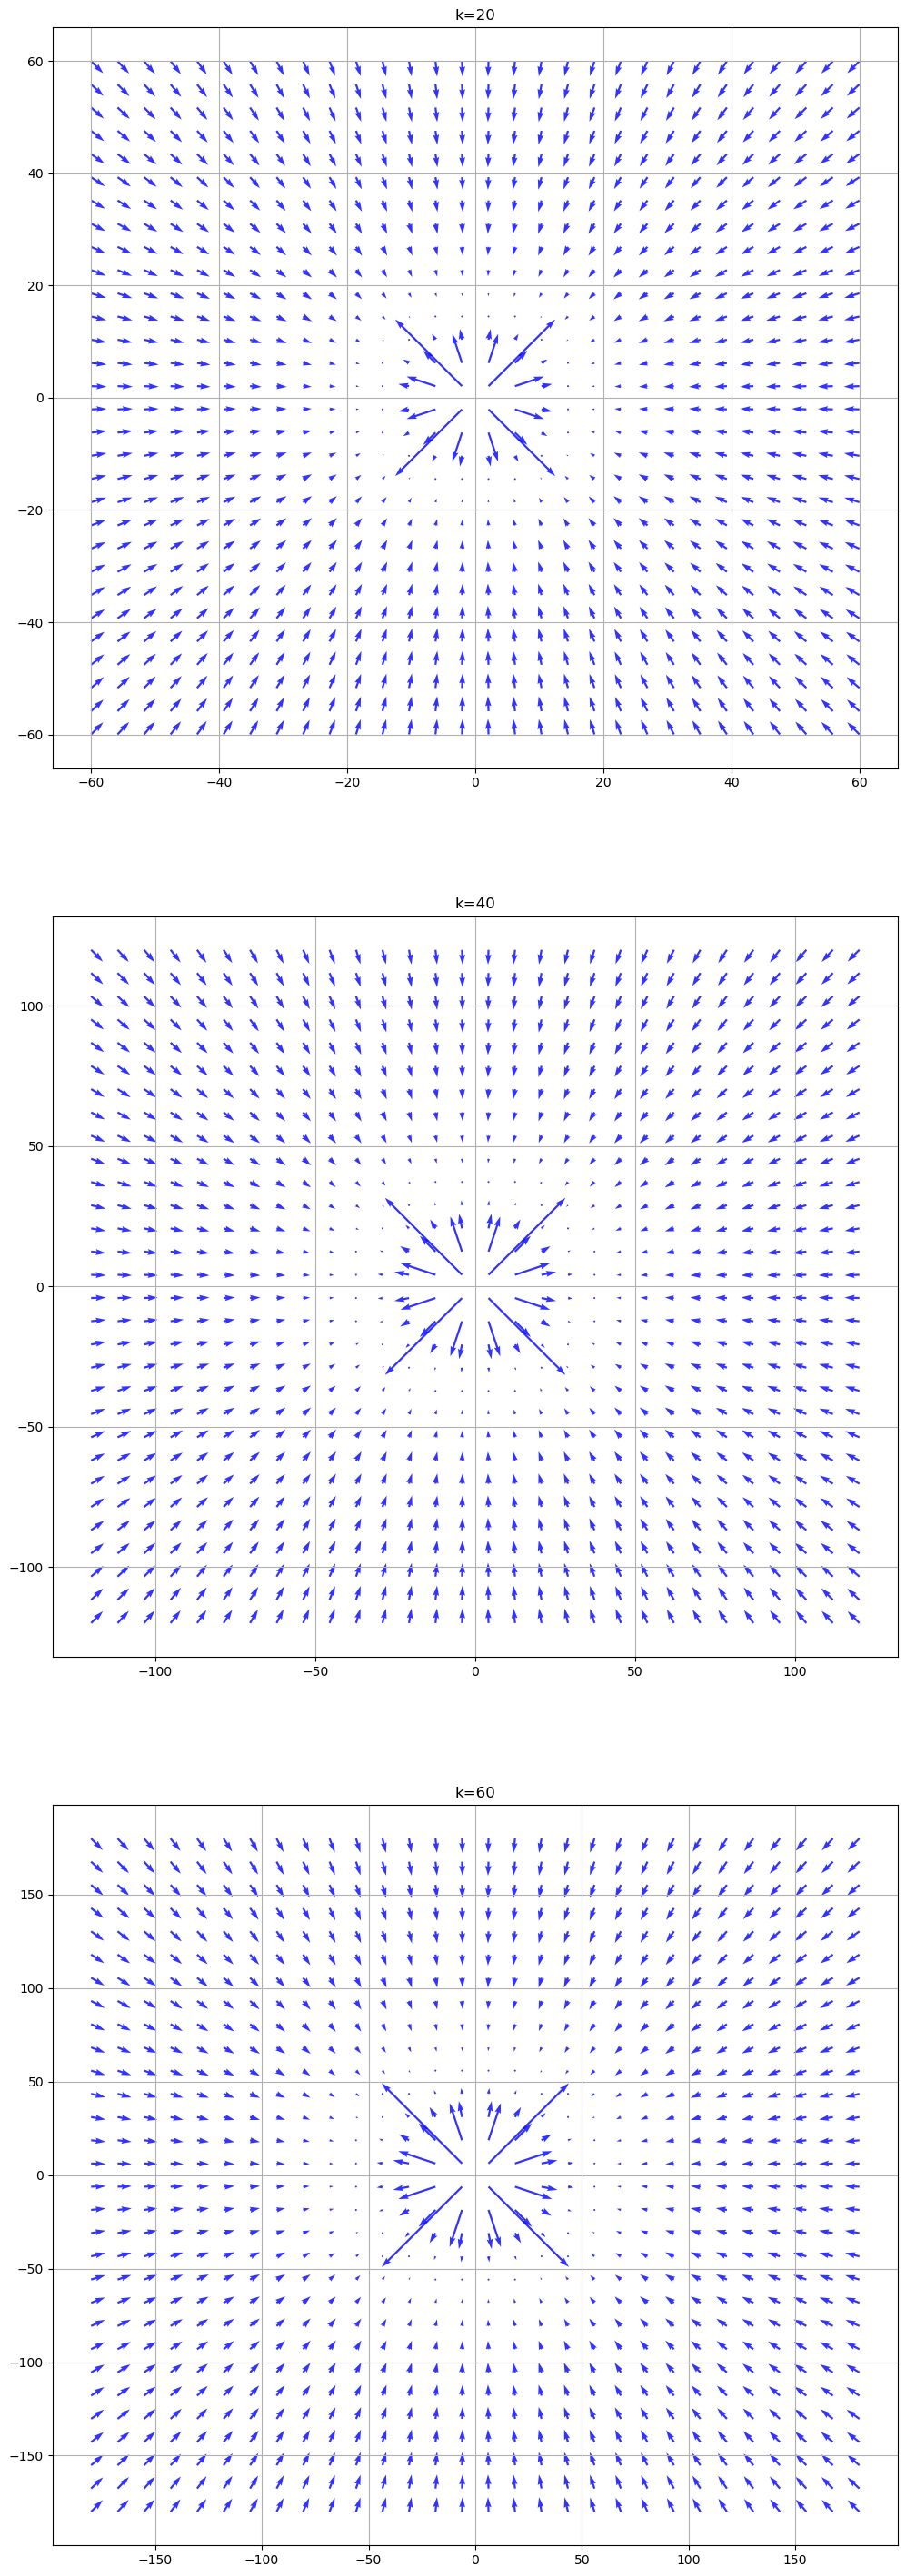

In [336]:
fig, ax = plt.subplots(ncols=1, nrows=3, figsize=(12, 36))
precision = 30
ks = [20, 40, 60]

for i, k in enumerate(ks):
    ax[i].set_title(f"k={k}")
    
    x = np.linspace(-3*k, 3*k, precision)
    y = np.linspace(-3*k, 3*k, precision)
    x_mesh, y_mesh = np.meshgrid(x, y)
    
    gx, gy = gradient_log_target(x_mesh, y_mesh, k)
    
    ax[i].quiver(x_mesh, y_mesh, gx, gy, scale=20, color='blue', alpha=0.8)
    ax[i].grid(True)

plt.show()

In [38]:
def target_distribution_vector(v: np.array, k: int, epsilon: float = 10e-9) -> float:
    return max(np.sum(v ** 2)**(k/4 - 1) * np.exp(-(np.sqrt(np.sum(v ** 2))) / 2), epsilon)
    
def gradient_log_target_vector(v, k, epsilon=1e-9):
    r = np.sqrt(np.maximum(np.sum(v**2), epsilon))
    factor = (k / 4 - 1) * 2 / r - 1/2
    return v/r * factor

def langevin_proposal(v, k, step_size, 
                      grad_log_target = gradient_log_target_vector):
    g = grad_log_target(v, k)
    s = step_size
    return np.random.multivariate_normal(mean=v + (s * g), cov=2 * s * np.identity(2))

def langevin_pdf(v1, v, k, step_size, 
                 grad_log_target = gradient_log_target_vector):
    # probability of going from x -> x1 given langevin proposals
    g = grad_log_target(v, k)
    s = step_size
    return stats.multivariate_normal.pdf(v1, mean=v + (s * g), cov=2 * s * np.identity(2))

In [40]:
def metropolis_adjusted_langevin(k, step_size, N=100000,
                                 target_dist = target_distribution_vector, 
                                 grad_log_target = gradient_log_target_vector):
    x_samples, y_samples = [], []
    v = np.array([0, 0])
    accepted_samples = 0

    progress_bar = tqdm(total=N, leave=True)
    while len(x_samples) < N:
        v1 = langevin_proposal(v, k, step_size)

        a = min(
            1,
            (target_dist(v1, k=k) * langevin_pdf(v, v1, k, step_size, grad_log_target=grad_log_target)) /
            (target_dist(v, k=k) * langevin_pdf(v1, v, k, step_size, grad_log_target=grad_log_target))
        )
        
        if stats.uniform.rvs() < a:
            v = v1
            accepted_samples += 1
            
        x_samples.append(v[0])
        y_samples.append(v[1]) 
        progress_bar.update(1)

    # Compute acceptance rate
    acceptance_rate = accepted_samples / N
    print(f"Acceptance rate: {acceptance_rate:.2f}")
            
    return np.array(x_samples), np.array(y_samples)

In [758]:
mhl_xs, mhl_ys = [], []
for k in ks:
    x, y = metropolis_adjusted_langevin(k=k, step_size=5*k, N=100000)
    mhl_xs.append(x)
    mhl_ys.append(y)

  0%|          | 0/100000 [00:00<?, ?it/s]

Acceptance rate: 0.49


  0%|          | 0/100000 [00:00<?, ?it/s]

Acceptance rate: 0.42


  0%|          | 0/100000 [00:00<?, ?it/s]

Acceptance rate: 0.41


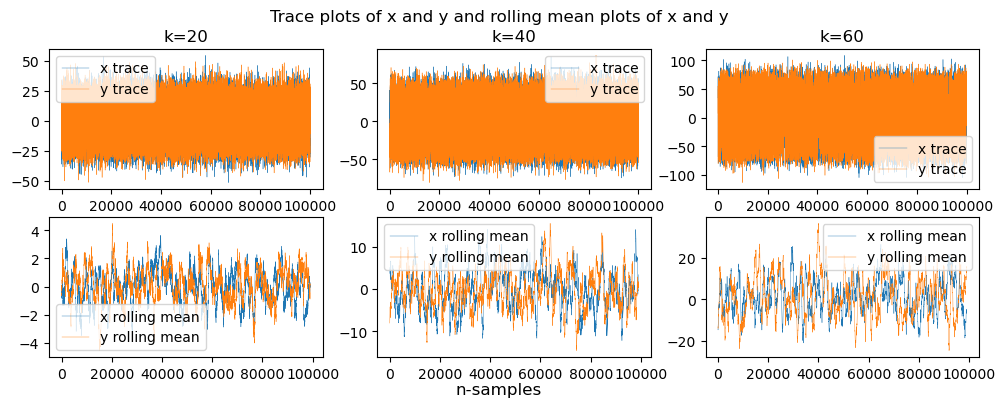

In [759]:
fig, ax = plt.subplots(ncols=3, nrows=2, figsize=(12, 4))

for i, (k, x, y) in enumerate(zip(ks, mhl_xs, mhl_ys)):
    ax[0][i].plot(x, label='x trace', lw=0.3)
    ax[0][i].plot(y, label='y trace', lw=0.3)
    ax[0][i].set_title(f"k={k}")
    ax[0][i].legend()
    
    x_running_mean = moving_window_mean(x.flatten().tolist(), window_size=1000)
    y_running_mean = moving_window_mean(y.flatten().tolist(), window_size=1000)
    ax[1][i].plot(x_running_mean, label='x rolling mean', lw=0.3)
    ax[1][i].plot(y_running_mean, label='y rolling mean', lw=0.3)
    ax[1][i].legend()
    
fig.supxlabel('n-samples')
fig.suptitle('Trace plots of x and y and rolling mean plots of x and y')
plt.show()

k=20, no. of burn in samples removed: 10000, no. of samples remaining: 90000
k=40, no. of burn in samples removed: 10000, no. of samples remaining: 90000
k=60, no. of burn in samples removed: 10000, no. of samples remaining: 90000


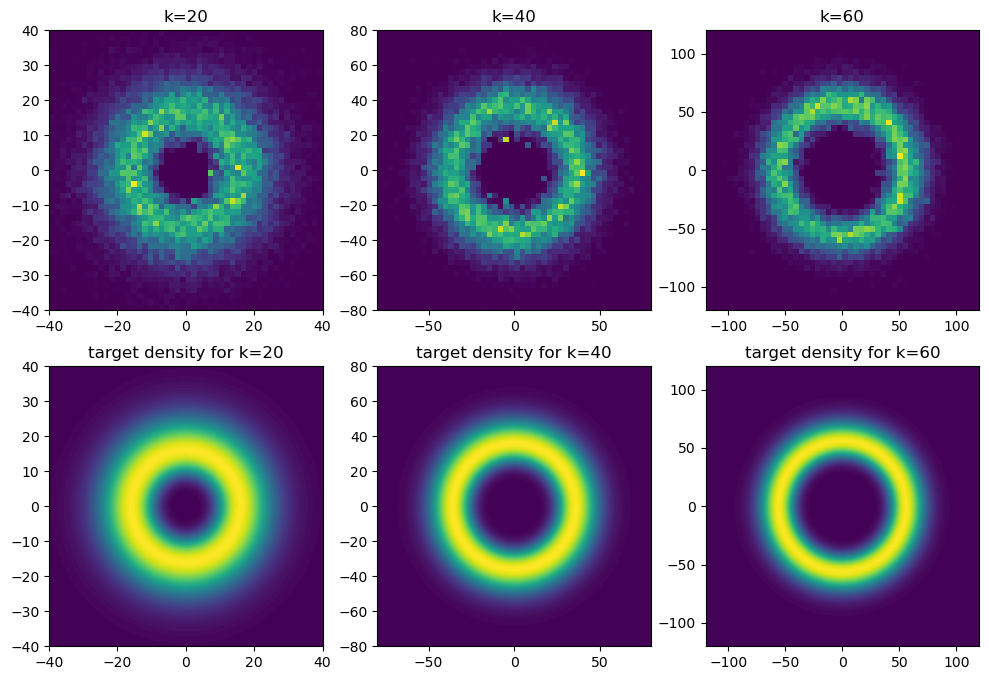

In [760]:
fig, ax = plt.subplots(ncols=3, nrows=2, figsize=(12, 8))
burnin_percentage = 0.1

for i, (k, x, y) in enumerate(zip(ks, mhl_xs, mhl_ys)):
    
    burnin = int(np.floor(burnin_percentage * len(x)))
    print(f'k={k}, no. of burn in samples removed: {burnin}, no. of samples remaining: {len(x) - burnin}')
    
    ax[0][i].hist2d(x[burnin:], y[burnin:], bins=50, cmap='viridis', range=[[-2*k, 2*k], [-2*k, 2*k]])
    ax[0][i].set_title(f"k={k}")

    X, Y, Z = get_target_density_samples(k=k)
    ax[1][i].contourf(X, Y, Z, levels=100)
    ax[1][i].set_title(f'target density for k={k}')
plt.show()

## 1.4 Implementation of autocorrelation estimator

In [42]:
def autocorrelation(samples: np.array, max_lag=100) -> np.array:
    x_bar = np.mean(samples)
    n = len(samples)
    var = np.var(samples)
    
    # return [COV / CAR for lag in range(1, max_range + 1)]
    return [np.sum(((samples[:n-lag] - x_bar) * (samples[lag:] - x_bar)) / (n - lag)) / var for lag in range(1, max_lag+1)]

### demonstration of autocorrelation estimator

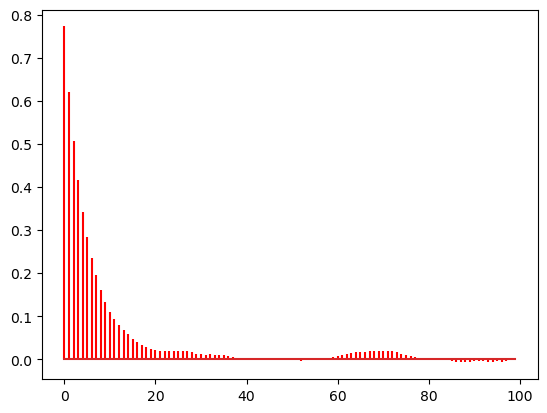

In [496]:
plt.stem(range(100), autocorrelation(mhl_xs[0][burnin:]), linefmt="red", markerfmt=" ")
plt.show()

## 1.5 Computing autocorrelation on each MH sampler for $k=40$, $N=100000$, $lag=100$

In [606]:
k=40
N=100000
max_lag=100

burnin=10000

# rw samples
sigmas = [0.4, 0.8, 1, 1.2, 1.4, 1.8]
rw_samples = [metropolis_hastings_random_walk(k=k, N=N, sigma=s*k) for s in sigmas]

  0%|          | 0/100000 [00:00<?, ?it/s]

Acceptance rate: 0.54


  0%|          | 0/100000 [00:00<?, ?it/s]

Acceptance rate: 0.35


  0%|          | 0/100000 [00:00<?, ?it/s]

Acceptance rate: 0.30


  0%|          | 0/100000 [00:00<?, ?it/s]

Acceptance rate: 0.25


  0%|          | 0/100000 [00:00<?, ?it/s]

Acceptance rate: 0.21


  0%|          | 0/100000 [00:00<?, ?it/s]

Acceptance rate: 0.15


In [607]:
# remove burn in
rw_samples_b = [(x[burnin:], y[burnin:]) for (x, y) in rw_samples]
# calculate autocorrelation
autocorrs = [(autocorrelation(x, max_lag=max_lag), 
              autocorrelation(y, max_lag=max_lag))  
             for (x, y) in rw_samples_b]

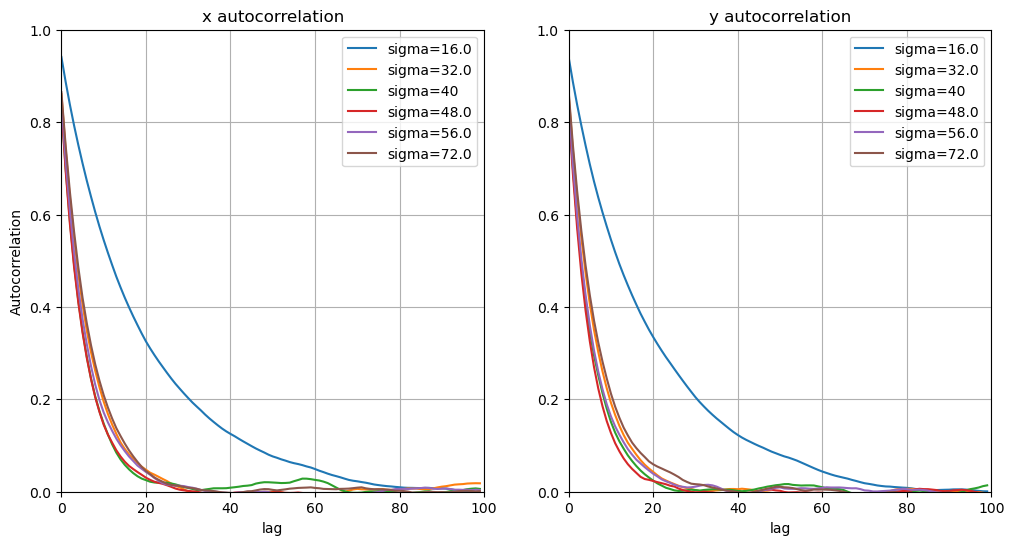

In [608]:
fix, ax = plt.subplots(ncols=2, nrows=1, figsize=(12, 6))

for s, (corr_x, corr_y) in zip(sigmas, autocorrs):
    lbl = f'sigma={s*k}'
    
    ax[0].plot(corr_x, label=lbl)
    ax[0].set_xlim(0, 100)
    ax[0].set_ylim(0, 1)
    
    ax[1].plot(corr_y, label=lbl)
    ax[1].set_xlim(0, 100)
    ax[1].set_ylim(0, 1)

ax[0].legend()
ax[1].legend()
ax[0].set_ylabel('Autocorrelation')
ax[0].set_xlabel('lag')
ax[1].set_xlabel('lag')
ax[0].set_title('x autocorrelation')
ax[1].set_title('y autocorrelation')
ax[0].grid('lag')
ax[1].grid('lag')
fig.suptitle('he')
plt.show()

In [761]:
# rw samples
steps = [2, 3, 4, 5, 6, 7, 8, 9]
mala_samples = [metropolis_adjusted_langevin(k=k, N=N, step_size=s*k) for s in steps]

  0%|          | 0/100000 [00:00<?, ?it/s]

Acceptance rate: 0.76


  0%|          | 0/100000 [00:00<?, ?it/s]

Acceptance rate: 0.62


  0%|          | 0/100000 [00:00<?, ?it/s]

Acceptance rate: 0.19


  0%|          | 0/100000 [00:00<?, ?it/s]

Acceptance rate: 0.40


  0%|          | 0/100000 [00:00<?, ?it/s]

Acceptance rate: 0.34


  0%|          | 0/100000 [00:00<?, ?it/s]

Acceptance rate: 0.29


  0%|          | 0/100000 [00:00<?, ?it/s]

Acceptance rate: 0.25


  0%|          | 0/100000 [00:00<?, ?it/s]

Acceptance rate: 0.23


In [762]:
# remove burn in
mala_samples_b = [(x[burnin:], y[burnin:]) for (x, y) in mala_samples]
# calculate autocorrelation
mala_autocorrs = [(autocorrelation(x, max_lag=max_lag), 
              autocorrelation(y, max_lag=max_lag))  
             for (x, y) in mala_samples_b]

NameError: name 'steps' is not defined

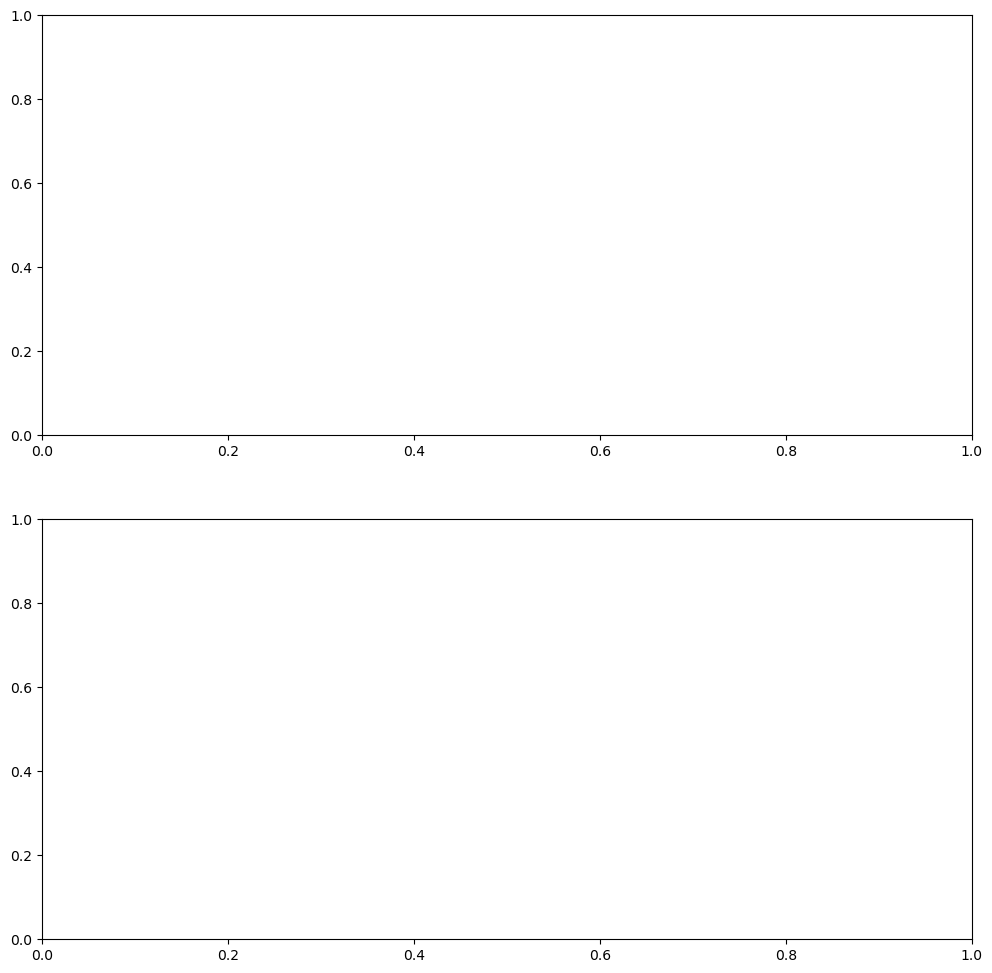

In [129]:
fix, ax = plt.subplots(ncols=2, nrows=1, figsize=(12, 6))

for s, (corr_x, corr_y) in zip(steps, mala_autocorrs):
    lbl = f'step_size={s*k}'
    
    ax[0].plot(corr_x, label=lbl)
    ax[0].set_xlim(0, 100)
    ax[0].set_ylim(0, 1)
    
    ax[1].plot(corr_y, label=lbl)
    ax[1].set_xlim(0, 100)
    ax[1].set_ylim(0, 1)

ax[0].legend()
ax[1].legend()
ax[0].set_ylabel('Autocorrelation')
ax[0].set_xlabel('lag')
ax[1].set_xlabel('lag')
ax[0].set_title('x autocorrelation')
ax[1].set_title('y autocorrelation')
ax[0].grid('lag')
ax[1].grid('lag')
plt.show()

# Q2: Bayesian Inference with a GMM prior

## 2.1 Exact GMM sampler

In [8]:
def exact_GMM_prior_sampler(m, s0_sq, N=100000):
    samples = np.mean([
        np.random.multivariate_normal(mean=mu, cov=s0_sq*np.identity(2), size=N) for mu in m
    ], axis=0)
    return samples[:, 0], samples[:, 1]

In [13]:
m = np.array([[4, 0], [0, 4], [-4, 0], [0, -4], [4, 4], [4, -4], [-4, 4], [-4, -4], [0, 0]])
s0_sq = 0.1

x, y = exact_GMM_prior_sampler(m, s0_sq)

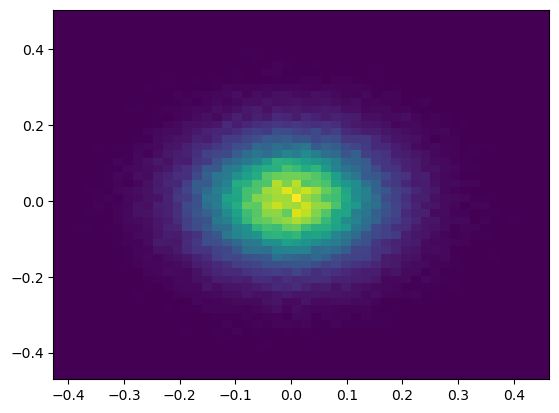

In [15]:
plt.hist2d(x, y, bins=50, cmap='viridis')
plt.show()

## 2.2 RW MH sampler for posterior density $p(x|y)$

$$
p(x|y) = \frac{p(y|x)p(x)}{p(y)} \propto p(y|x)p(x)
$$

In [650]:
def prior_pdf(x, m, s0_sq=0.1):
    prob = 0.
    for mu1, mu2 in m:
        p1, p2 = np.exp(-((x[0] - mu1) ** 2)/(2 * s0_sq)), np.exp(-((x[1] - mu2) ** 2)/(2 * s0_sq))
        prob += (p1 * p2) / (2 * np.pi * s0_sq)
    return prob/9
    
def likelihood_pdf(y, x, s_sq=2):
    return np.exp(-((y - x[0] - x[1])**2)/(2 * s_sq)) / np.sqrt(2 * np.pi * s_sq)

def likelihood(x, s_sq):
    return np.random.normal(loc=np.sum(x), scale=s_sq)

def rw_mh_posterior(m, s_sq, s0_sq, N=100000, burnin=10000, sigma=1, epsilon=10e-9):
    v = np.array([0, 0])
    y = 0
    
    v_samples = []
    accepted_samples = 0
    
    progress_bar = tqdm(total=N + burnin, leave=True)
    while len(v_samples) < N + burnin:
        v1 = np.random.multivariate_normal(mean=v, cov= sigma * np.identity(2))
        
        original = prior_pdf(v, m) * likelihood_pdf(y, v)
        proposal = prior_pdf(v1, m) * likelihood_pdf(y, v1)

        a = min(1, proposal/original)

        if np.random.uniform() < a:
            v = v1
            accepted_samples += 1

        v_samples.append(v)
        progress_bar.update(1)

    # Compute acceptance rate
    acceptance_rate = accepted_samples / N
    print(f"Acceptance rate: {acceptance_rate:.2f}")

    v_samples = np.array(v_samples)
    return v_samples[burnin:, 0], v_samples[burnin:, 1]

In [652]:
m = np.array([[4, 0], [0, 4], [-4, 0], [0, -4], [4, 4], [4, -4], [-4, 4], [-4, -4], [0, 0]])
s0_sq = 0.1
s_sq = 2

rw_x, rw_y = rw_mh_posterior(m, s_sq, s0_sq, N=100000, sigma=12)

  0%|          | 0/110000 [00:00<?, ?it/s]

Acceptance rate: 0.03


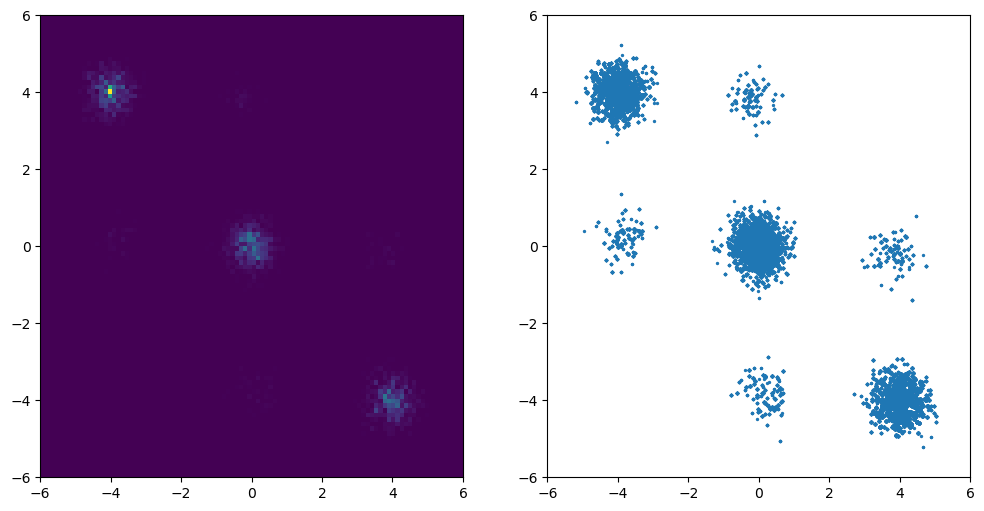

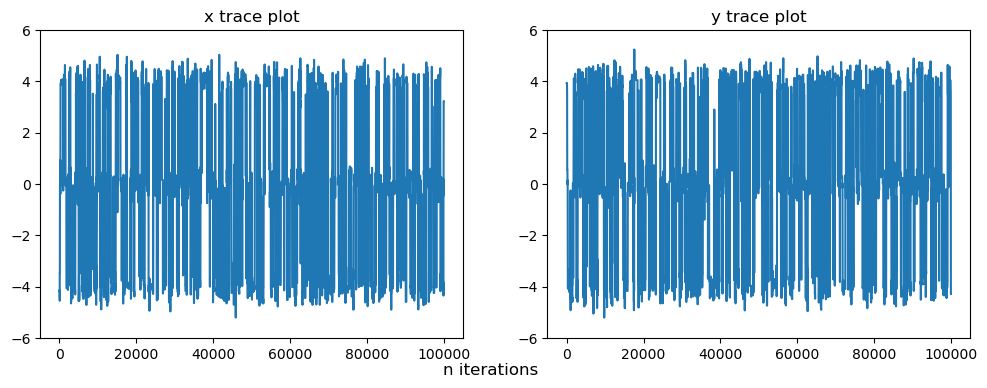

In [663]:
fig, ax = plt.subplots(ncols=2, nrows=1, figsize=(12, 6))
ax[0].hist2d(rw_x, rw_y, bins=100, cmap='viridis', range=[[-6, 6], [-6, 6]])
ax[1].scatter(rw_x, rw_y, s=2)
ax[1].set_xlim(-6, 6)
ax[1].set_ylim(-6, 6)
plt.show()
fig, ax = plt.subplots(ncols=2, nrows=1, figsize=(12, 4))
ax[0].plot(rw_x)
ax[0].set_ylim((-6, 6))
ax[0].set_title('x trace plot')
ax[1].plot(rw_y)
ax[1].set_ylim((-6, 6))
ax[1].set_title('y trace plot')
fig.supxlabel('n iterations')
plt.show()

### 2.3 Metropolis-adjusted Langevin algorithm (MALA)

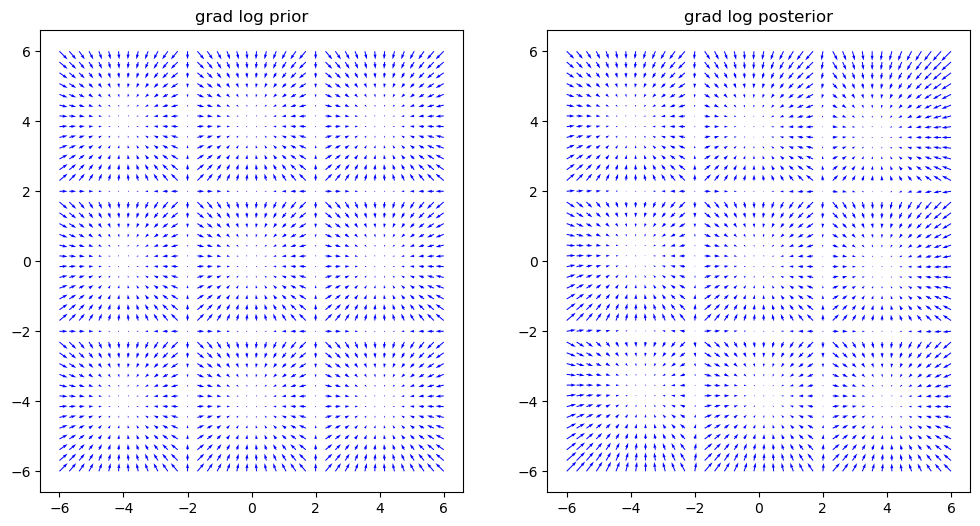

In [482]:
def grad_log_prior(x, m, s0_sq):
    w = np.array([np.exp(np.sum((x - mu)**2) / (-2*s0_sq)) for mu in m])
    return -np.sum(w[:, None] * (x - m), axis=0) / (s0_sq * np.sum(w))

def grad_log_posterior(x, m, s0_sq, s_sq, H=np.array([1, 1])):
    grad_lp = grad_log_prior(x, m, s0_sq)
    grad_log_likelihood = ((y - H.dot(x)) / s_sq) * H
    return grad_lp + grad_log_likelihood


m = np.array([[4, 0], [0, 4], [-4, 0], [0, -4], [4, 4], [4, -4], [-4, 4], [-4, -4], [0, 0]])
s0_sq = 0.1
s_sq = 2
y = 0
precision = 40

x1, x2 = np.meshgrid(np.linspace(-6, 6, precision), np.linspace(-6, 6, precision))
grid_points = np.stack([x1.ravel(), x2.ravel()], axis=1)

prior = np.array([grad_log_prior(point, m, s0_sq) for point in grid_points]).reshape(precision, precision, 2)
posterior = np.array([grad_log_posterior(point, m, s0_sq, s_sq) for point in grid_points]).reshape(precision, precision, 2)

fig, ax = plt.subplots(ncols=2, nrows=1, figsize=(12, 6))
ax[0].quiver(x1, x2, prior[:, :, 0], prior[:, :, 1], color='blue')
ax[0].set_title('grad log prior')
ax[1].quiver(x1, x2, posterior[:, :, 0], posterior[:, :, 1], color='blue')
ax[1].set_title('grad log posterior')
plt.show()

In [623]:
def grad_log_prior(x, m, s0_sq=0.1):
    w = np.array([np.exp(np.sum((x - mu)**2) / (-2*s0_sq)) for mu in m])
    return -np.sum(w[:, None] * (x - m), axis=0) / (s0_sq * np.sum(w))

def grad_log_likelihood(y, x, H, s_sq=2):
    return ((y - H.dot(x)) / s_sq) * H
    
def grad_log_posterior(x, m, s0_sq=0.1, s_sq=2, H=np.array([1, 1]), y=0):
    grad_lp = grad_log_prior(x, m, s0_sq)
    grad_ll = grad_log_likelihood(0, x, H)
    return grad_lp + grad_ll
    
def gmm_langevin_proposal(v, m, step_size, s0_sq=0.1, s_sq=2):
    g = grad_log_posterior(v, m)
    return np.random.multivariate_normal(mean=v + (step_size * g), cov=2 * step_size * np.identity(2))

def gmm_langevin_pdf(v1, v, m, step_size):
    # probability of going from v -> v1 given langevin proposals
    return -np.sum((v1 - (v + step_size * grad_log_posterior(v, m)))**2)/(4*step_size)
    
def log_posterior(x, y, m):
    return np.log(prior_pdf(x, m) * likelihood_pdf(y, x))

In [656]:
def mala_mh_posterior(m, step_size, N=100000, burnin=10000, s_sq=2, s0_sq=0.1):
    v = np.array([0, 0])
    y = 0
    v_samples = []
    accepted_samples = 0
    
    progress_bar = tqdm(total=N + burnin, leave=True)
    while len(v_samples) < N + burnin:
        v1 = gmm_langevin_proposal(v, m, step_size)
        
        log_original = log_posterior(v, y, m)
        log_proposal = log_posterior(v1, y, m)
        
        log_q_prop, log_q_curr = gmm_langevin_pdf(v1, v, m, step_size), gmm_langevin_pdf(v, v1, m, step_size)
        
        log_a = (log_proposal - log_original) + (log_q_prop - log_q_curr)
        
        a = min(1, np.exp(log_a))

        if np.random.uniform() < a:
            v = v1
            accepted_samples += 1

        v_samples.append(v)
        progress_bar.update(1)

    # Compute acceptance rate
    acceptance_rate = accepted_samples / N
    print(f"Acceptance rate: {acceptance_rate:.2f}")

    v_samples = np.array(v_samples)
    return v_samples[burnin:, 0], v_samples[burnin:, 1]

In [658]:
m = np.array([[4, 0], [0, 4], [-4, 0], [0, -4], [4, 4], [4, -4], [-4, 4], [-4, -4], [0, 0]])
s0_sq = 0.1
s_sq = 2
y = 0

mala_x, mala_y = mala_mh_posterior(m, step_size=0.15)

  0%|          | 0/110000 [00:00<?, ?it/s]

Acceptance rate: 0.36


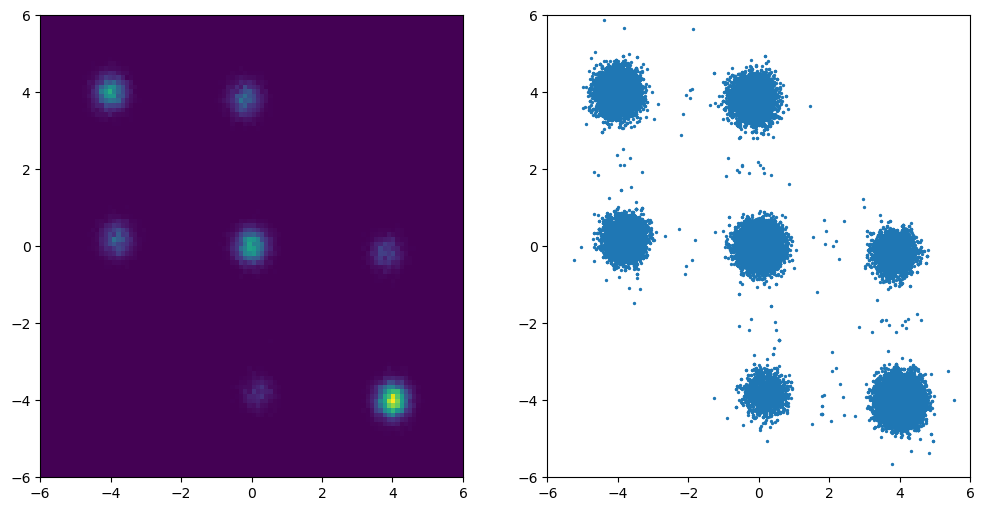

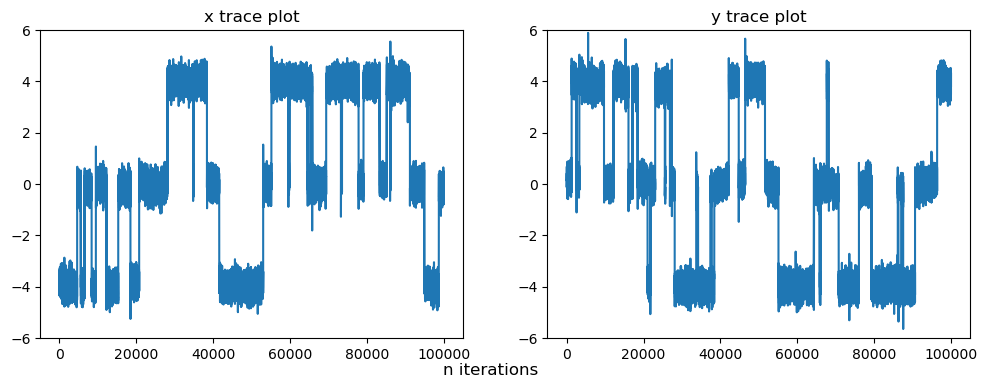

In [660]:
fig, ax = plt.subplots(ncols=2, nrows=1, figsize=(12, 6))
ax[0].hist2d(mala_x, mala_y, bins=100, cmap='viridis', range=[[-6, 6], [-6, 6]])
ax[1].scatter(mala_x, mala_y, s=2)
ax[1].set_xlim(-6, 6)
ax[1].set_ylim(-6, 6)
plt.show()
fig, ax = plt.subplots(ncols=2, nrows=1, figsize=(12, 4))
ax[0].plot(mala_x)
ax[0].set_ylim((-6, 6))
ax[0].set_title('x trace plot')
ax[1].plot(mala_y)
ax[1].set_ylim((-6, 6))
ax[1].set_title('y trace plot')
fig.supxlabel('n iterations')
plt.show()

### 2.4 Unadjusted Langevin Algorithm (ULA)

In [679]:
def ula(y, mu_list, step, N=100000, burnin=10000, sigma_0=0.1, sigma_y=2.0, H = np.array([1.0, 1.0])):
    v = np.array([0.0, 0.0])
    v_samples = []

    progress_bar = tqdm(total=N+burnin, leave=True)
    while len(v_samples) < (N+burnin):
        # Compute gradients
        grad_p = grad_log_prior(v, mu_list)
        grad_l = grad_log_likelihood(y, v, H)
        
        # Langevin update
        v = v + step * (grad_l + grad_p) + np.sqrt(2 * step) * np.random.normal(size=2)
        
        v_samples.append(v)
        progress_bar.update(1)

    v_samples = np.array(v_samples)
    return v_samples[burnin:, 0], v_samples[burnin:, 1]

In [681]:
m = np.array([[4, 0], [0, 4], [-4, 0], [0, -4], [4, 4], [4, -4], [-4, 4], [-4, -4], [0, 0]])
y = 0
step = 0.15
ula_x, ula_y = ula(y, mu_list, step)

  0%|          | 0/110000 [00:00<?, ?it/s]

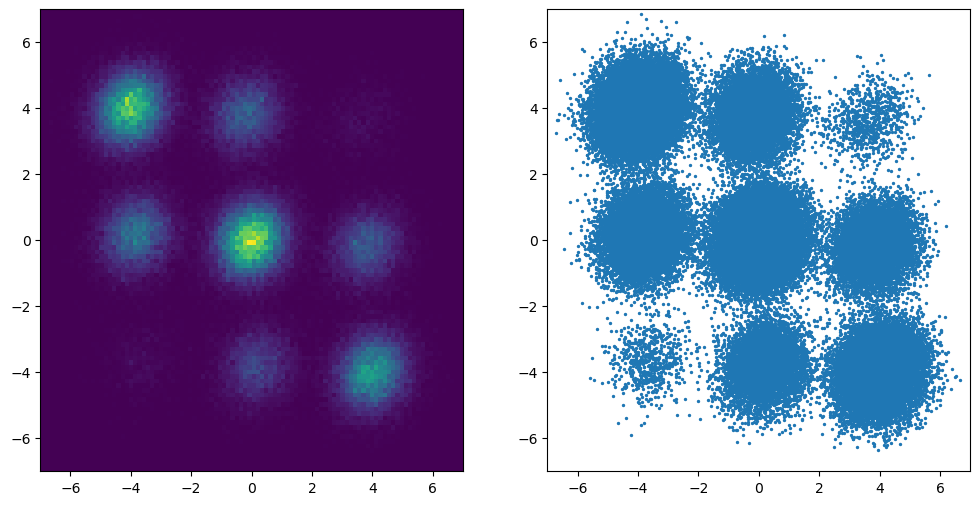

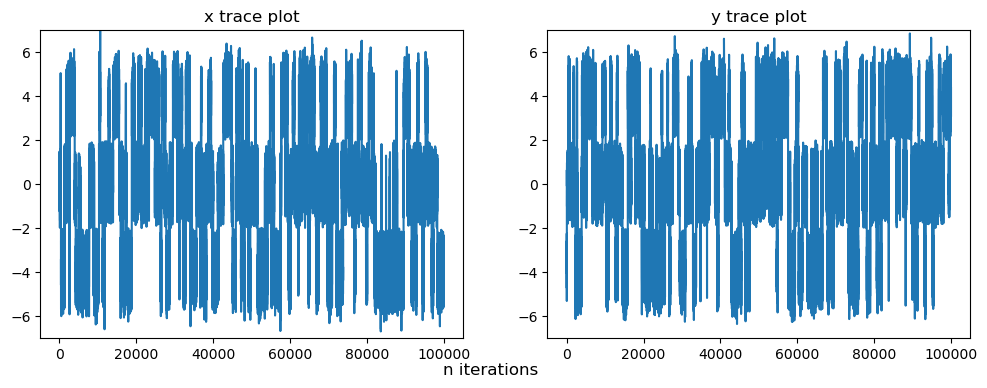

In [687]:
fig, ax = plt.subplots(ncols=2, nrows=1, figsize=(12, 6))
ax[0].hist2d(ula_x, ula_y, bins=100, cmap='viridis', range=[[-7, 7], [-7, 7]])
ax[1].scatter(ula_x, ula_y, s=2)
ax[1].set_xlim(-7, 7)
ax[1].set_ylim(-7, 7)
plt.show()
fig, ax = plt.subplots(ncols=2, nrows=1, figsize=(12, 4))
ax[0].plot(ula_x)
ax[0].set_ylim((-7, 7))
ax[0].set_title('x trace plot')
ax[1].plot(ula_y)
ax[1].set_ylim((-7, 7))
ax[1].set_title('y trace plot')
fig.supxlabel('n iterations')
plt.show()

### 2.5 Importance Sample Resampler

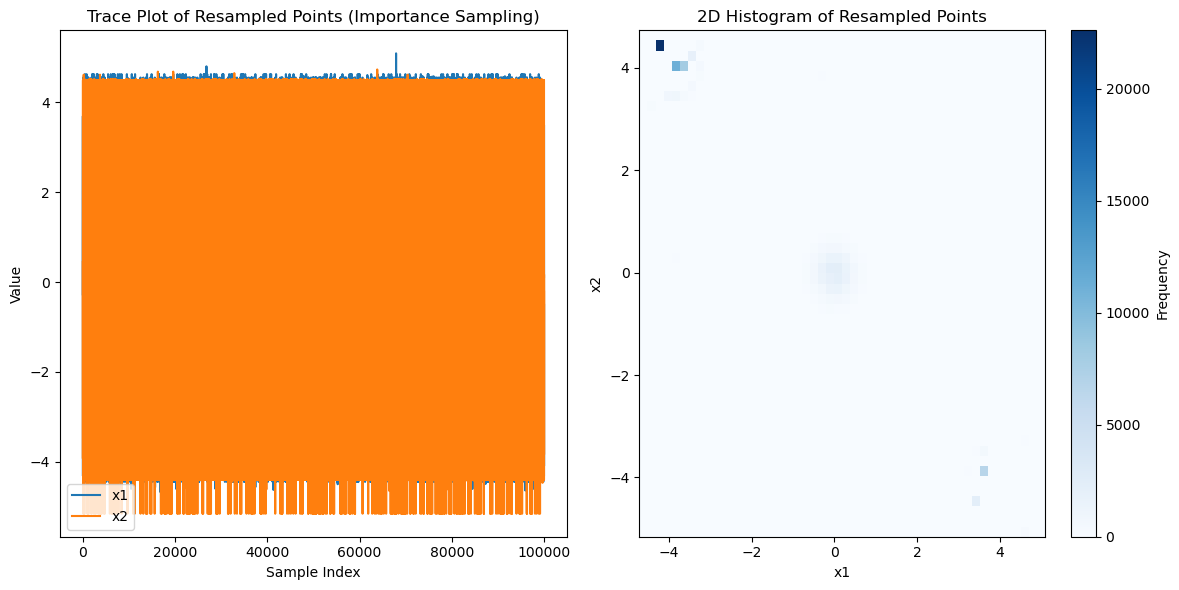

(1e-05, 7.555817452734848e-07, 0.22632770494012028)

In [345]:
# Re-import necessary libraries and reinitialize constants
import numpy as np
import matplotlib.pyplot as plt

# Reinitialize constants for posterior and proposal distributions
sigma0_squared = 0.1  # Variance for GMM prior
sigma_y_squared = 2.0  # Variance for likelihood
H = np.array([1, 1])  # H matrix for likelihood
mu_means = np.array([
    [4, 0], [0, 4], [-4, 0], [0, -4], [4, 4], 
    [4, -4], [-4, 4], [-4, -4], [0, 0]
])  # Means for GMM prior

# Define prior, posterior, and proposal distributions
def gmm_prior(x):
    density = 0
    for mu in mu_means:
        density += (1 / 9) * np.exp(-0.5 * np.sum((x - mu)**2) / sigma0_squared)
    return density

def log_prior(x):
    return np.log(gmm_prior(x) + 1e-10)

def grad_log_prior(x):
    gradient = np.zeros_like(x, dtype=np.float64)
    for mu in mu_means:
        weight = np.exp(-0.5 * np.sum((x - mu)**2) / sigma0_squared)
        gradient += weight * (mu - x) / sigma0_squared
    density = gmm_prior(x)
    gradient /= (density + 1e-10)
    return gradient

def log_posterior(x, y=0):
    likelihood = np.exp(-0.5 * (y - np.dot(H, x))**2 / sigma_y_squared)
    return log_prior(x) + np.log(likelihood + 1e-10)

def target_density(x):
    return np.exp(log_posterior(x))

# Proposal distribution
proposal_mean = np.array([0, 0])
proposal_cov = np.eye(2) * 2.0

def proposal_density(x):
    return np.exp(-0.5 * x @ np.linalg.inv(proposal_cov) @ x) / \
           (2 * np.pi * np.sqrt(np.linalg.det(proposal_cov)))

def proposal_sampler(n_samples):
    return np.random.multivariate_normal(proposal_mean, proposal_cov, size=n_samples)

# Importance Sampling Implementation
def importance_sampling(target_density, proposal_density, proposal_sampler, n_samples):
    samples = proposal_sampler(n_samples)
    weights = np.array([
        target_density(sample) / (proposal_density(sample) + 1e-10) for sample in samples
    ])
    weights /= np.sum(weights)  # Normalize weights
    indices = np.random.choice(np.arange(n_samples), size=n_samples, p=weights)
    resampled_points = samples[indices]
    return resampled_points, weights

# Perform importance sampling
n_samples = 100000
resampled_points, weights = importance_sampling(target_density, proposal_density, proposal_sampler, n_samples)

# Trace plot and 2D histogram of resampled points
plt.figure(figsize=(12, 6))

# Trace plot
plt.subplot(1, 2, 1)
plt.plot(resampled_points[:, 0], label='x1')
plt.plot(resampled_points[:, 1], label='x2')
plt.title('Trace Plot of Resampled Points (Importance Sampling)')
plt.xlabel('Sample Index')
plt.ylabel('Value')
plt.legend()

# 2D Histogram of resampled points
plt.subplot(1, 2, 2)
plt.hist2d(resampled_points[:, 0], resampled_points[:, 1], bins=50, cmap='Blues')
plt.colorbar(label='Frequency')
plt.title('2D Histogram of Resampled Points')
plt.xlabel('x1')
plt.ylabel('x2')

plt.tight_layout()
plt.show()

# Analyze the importance weights
weights_mean = np.mean(weights)
weights_var = np.var(weights)
weights_max = np.max(weights)

weights_mean, weights_var, weights_max
